In [34]:
import nidaqmx 
import atiiaftt as ati
import time
import numpy as np
from nidaqmx.stream_readers import AnalogMultiChannelReader
import matplotlib.pyplot as plt

In [27]:
CALFILEPATH = "..\FT44764\FT44764.cal"
INDEX = 1

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    
    readings = task.read()

sampleTT = [0,0,0,0,0,0]

sensor = ati.FTSensor()
cal = sensor.createCalibration(CALFILEPATH, INDEX)
sensor.setForceUnits("N".encode("utf-8"))
sensor.setTorqueUnits("N-m".encode("utf-8"))
sensor.setToolTransform(sampleTT, "mm".encode("utf-8"), "deg".encode("utf-8"))

# bias = readings[:6]
SG_output = readings[:6]
SG_ref = readings[6:]

# sensor.bias(bias)
output = sensor.convertToFt(SG_output)

print("SG output: ", SG_output)
print("SG red: ", SG_ref)
print("Force: ", output)

SG output:  [-0.0008272705845251277, -0.0006629283810171555, -0.0008272705845251277, -0.000498586177542587, -0.0006629283810171555, -0.000498586177542587]
SG red:  []
Force:  [0.0003087082877755165, -0.0026692342944443226, -0.057970255613327026, 0.0001043510201270692, -6.144104554550722e-05, 0.0007196905207820237]


In [29]:
current_time = time.time()
DURATION = 5
readings_outside_loop = []
with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
    task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
    while time.time() < current_time+DURATION:
        readings_outside_loop.append(sensor.convertToFt(task.read()))

# output_outside_loop = sensor.convertToFt(readings_outside_loop[0])
print(len(readings_outside_loop))

200


In [14]:
current_time = time.time()
readings_inside_loop = []
while time.time() < current_time+DURATION:
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
        task.ai_channels.add_ai_voltage_chan("Dev1/ai5")

        readings_inside_loop.append(task.read())

# output_inside_loop = sensor.convertToFt(readings_inside_loop[0])
print(len(readings_inside_loop))

171


In [33]:
readings_multi = []
read_task = nidaqmx.Task()
read_task.ai_channels.add_ai_voltage_chan("Dev1/ai0")
read_task.ai_channels.add_ai_voltage_chan("Dev1/ai1")
read_task.ai_channels.add_ai_voltage_chan("Dev1/ai2")
read_task.ai_channels.add_ai_voltage_chan("Dev1/ai3")
read_task.ai_channels.add_ai_voltage_chan("Dev1/ai4")
read_task.ai_channels.add_ai_voltage_chan("Dev1/ai5")
reader = AnalogMultiChannelReader(read_task.in_stream,)
values_read = np.zeros(6, dtype=np.float64)

current_time = time.time()
while time.time() < current_time+DURATION:
    reader.read_one_sample(values_read)
    
    readings_multi.append(sensor.convertToFt(values_read.tolist()))

print(len(readings_multi))

200


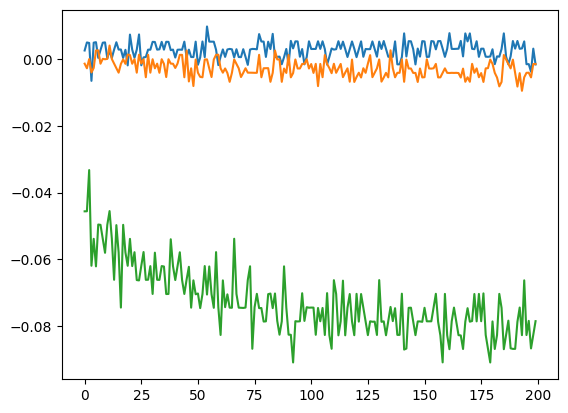

In [44]:
# plt.plot(range(len(readings_outside_loop)), [sample[0] for sample in readings_outside_loop])
# plt.plot(range(len(readings_outside_loop)), [sample[1] for sample in readings_outside_loop])
# plt.plot(range(len(readings_outside_loop)), [sample[2] for sample in readings_outside_loop])
# plt.plot(range(len(readings_multi)), [sample[0] for sample in readings_multi])
# plt.plot(range(len(readings_multi)), [sample[1] for sample in readings_multi])
# plt.plot(range(len(readings_multi)), [sample[2] for sample in readings_multi])